| Field      | Information                         |
|------------|-------------------------------------|
| **Author** | Abdelaziz Nematallah                |
| **Date**   | 2/11/2024                           |
| **Desc**   | This notebook is to solve the first part of lab1 |

#### Problem description: 
*  Cryptanalysis based on knowledge of the ciphertext only, i.e. without knowing any part of
 the plaintext, is the most difficult type of analysis. A method that can always be used is ex
haustive key search, where every key is tried out. For this lab you were provided a file called
 Subst-Rijndael.crypt, which contains the binary data of a text that has been encrypted
 twice, using monoalphabetic substitution first and then the AES algorithm in CBC mode. The AES
 encryption used a weak key, where from the 128bit key only the first 16bits were chosen and the
 rest of the key was padded with zeros. Here, the initialization vector (IV) is the first block of the
 ciphertext

### Solution steps
1. Since the encryption was done by two encryption algorithms:
   1. monoalphabetic 
   2. AES
2. Then to decrypt it correctly we need to apply the decryption in the reverse order
   1. AES decryption
   2. monoalphabetic decryption


## Task 1.1: Brute-force Weak AES
*  Thanks to the small key space, a brute-force attack on Subst-Rijndael.crypt becomes
 a reasonable technique to break the outer AES encryption layer. Write a short prototype script
 to automate the attack. To this end, you must find a criterion that allows you to automatically
 distinguish the right key from wrong ones. The decryption shall be computed and stored in
 Subst.txt (in plaintext format) for further processing in the next step. Furthermore, you should
 save the discovered AES key in aes.key as a hexadecimal text string.
 Hints:
 1. Notice that there are already many implementations (libraries) available to apply AES
 encryption and decryption, e.g., PyCryptodome to interface with Python.
 2. Take a look at Shannon entropy. How can it help to find out the correct key among all
 possible combinations?

### Solution steps: 
1. since the used key is weak, which consists of only 16 bits, so we need to apply brutefroce attack and try the all 2^16 possible keys
2. then we need to evaluate the Shannon entropy which indicates that natural language text should have lower entropy compared with the other random text. 
3. so we calculate the shanon entropy after decryption of each key, and select the key with the minimum value of shanon entropy. 
4.  finally, we can get the correct key and decrypt the ciphertext, and store the corresponding plaintext, and the key. 


In [1]:
# importing libraries
from Crypto.Cipher import AES
import struct
import math

In [2]:
def calculateShanonEntropy (data): 
    '''
        This method is responsible for evaluating shanon entropy for data sequence
        Logic: 
            if no data return 0 
            iterate over the unique items in the data, and evaluate its entropy using shanon equation :
                p(x) = # times x appeared / total length
                entropy -= p(x) * log2(p(x)) // high entropy means more randomness. 
            return entropy
    '''
    if not data:
        return 0
    entropy = 0 
    for item in set(data): 
        p = data.count(item) / len(data)
        entropy -= p * math.log(p, 2)
    return entropy

In [3]:
def AESBruteForceAttack(fileName):
    '''
        This method is to apply the brute force attack. 
        Logic: 
            1. open the file. 
            2. initialize the Initial vector with the first 16 bytes 
            3. create dummy variables to store the results in.
            4. iterate over the 2^16 possible keys. 
                4.1. construct the 128bits key by adding the possible key then pad it with 14 zeros bytes. 
                4.2. try to decrypt the cipher text using this key.
                4.3. evaluate the entropy of the decrypted file. 
                4.4. if the entropy is less than the best entropy
                    4.4.1. assign the new entropy as the best entropy
                    4.4.2. assign the best plain text to the current plain text
                    4.4.3. assign the best key to the current key. 
            5. store the best key and best plain text in a file.
    '''
    # Read encrypted file
    with open(fileName, 'rb') as f:
        cipherText = f.read()
    
    iv = cipherText[:16]  # Assuming IV is the first 16 bytes
    encryptedData = cipherText[16:]  # Rest is the encrypted content
    
    # Variables to store best key and plaintext based on entropy
    bestEntropy = float('inf')
    bestPlaintext = None
    bestKey = None

    # Try all 16-bit keys (0x0000 to 0xFFFF)
    for keyCandidate in range(0x10000):
        # Convert to a 128-bit key with padding: 0x0000 + 0's
        # struct.pack is used to convert the data into specific binary format. 
        # ">H" is the format string:
            # > specifies big-endian byte order (meaning the most significant byte comes first).
            # H indicates an unsigned short integer (16 bits).
        # our keyCandidate is 2 bytes (16 bits). 
        key = struct.pack(">H", keyCandidate) + b'\x00' * 14
        
        # AES decryption with CBC mode
        cipher = AES.new(key, AES.MODE_CBC, iv)
        try:
            decrypted_data = cipher.decrypt(encryptedData)
            
            # Check entropy
            entropy = calculateShanonEntropy(decrypted_data)
            if entropy < bestEntropy:
                bestEntropy = entropy
                bestPlaintext = decrypted_data
                bestKey = key
        except ValueError:
            # AES decryption failed (in case padding is incorrect)
            continue

    # Write best decryption output
    if bestPlaintext and bestKey:
        with open("Subst.txt", "wb") as f:
            f.write(bestPlaintext)
        
        with open("aes.key", "w") as f:
            f.write(bestKey.hex())

        print("Decryption successful!")
        print("AES key found:", bestKey.hex())

    else:
        print("No valid key found.")



In [4]:
# now lets try to apply this on our encryption file 
AESBruteForceAttack("Subst-Rijndael.crypt")

# it took around 30 seconds which means that we compute 2184.53 keys per second, and this number varies depending on processing power.

Decryption successful!
AES key found: a4e70000000000000000000000000000


* now we have broken the AES with weak key, lets now try to decrypt the monoalphabetic encryption
###  Task 1.2: The Hill-Climbing Method to Break Monoalphabetic Substitution
* To break the inner monoalphabetic substitution, a naive brute-force attack would require to test
 up to 26! ≈ 4·1026 possible permutations of the alphabet (assuming the alphabet A-Z only).
 Assuming each probe takes just 1µs, approximately **1013 years** would be required and you would
 likely miss the deadline for this task. Although frequency analysis can help us guess the scheme
 of the monoalphabetic substitution quickly, there is no guarantee that the key gained from this is
 **100% correct**. Therefore, an even more sophisticated method is required.
 
* The monoalphabetic substitution corresponds to a permutation of the alphabet, which can be
 represented by a substitution defined in a lookup table like the example depicted in table 1.
 
 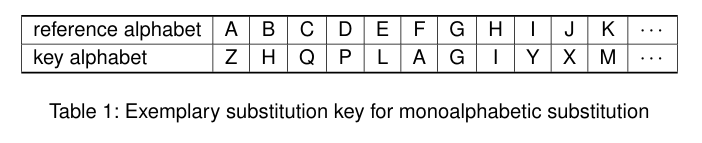

* From combinatorics, it is known that starting from an arbitrary permutation of a finite alphabet, we
 can define any key permutation by applying a finite number of transpositions (essentially, swaps
 of two characters in the alphabet). So assuming we start with the initial permutation I and the
 substitution permutation (i.e., the key) used for the monoalphabetic encryption is K, then there
 exist transpositions T1,T2,...,Tn, such that:
 K =Tn◦Tn−1◦···◦T1◦I.
 In other words, the encryption key can be found by finding the correct transpositions Ti, starting
 from an initial permutation I. That way the cryptanalysis becomes an iterative approach, where we
 successively test substitutions I, T1 ◦I, T2 ◦T1◦I, etc. and evaluate their impact until we find K.
 It can be assumed that a used transposition Ti is **correct if it increases the scored goodness of**
 **the decryption**. To formalize this idea into an algorithm called **hill climbing**, three critical questions
 have to be answered:
   1. How to choose the initialization key I, i.e., the permutation to start with?
   2. How to derive from one key, e.g., I, the following keys T1◦I, T2◦T1◦I, ...?
   3. How to measure the quality of each permutation, i.e., did we improve from Ti◦···◦T1◦I to Ti+1 ◦Ti ◦···◦T1◦I?
* So our task is to answer these questions and to implement, as well as to mount, the hill climbing approach to break the monoalphabetic cipher applied on Subst.txt. For a successful
 completion of this subtask, you have to implement the hill-climbing approach with a sensible
 key initialization routine and rules to derive a suitable next key. Submit your prototype imple
mentation as break_monoalphabetic.{py,cc,...}, or, if it consists of several source
 code files, submit it in a folder called break_monoalphabetic. Additionally, you shall submit
 the plaintext obtained as Plain.txt, as well as the substitution key found by your attack as
 subst.key (as a string, for example: VFTWIJNUCQAGDKLRZMHBSOEPXY). To guide you
 through this cryptanalysis, the following paragraphs will provide help regarding the questions
 mentioned above.
 

* **Initialization key:** The actual performance of the hill climbing attack will be heavily effected by  the initial key from where the algorithm starts. To this end, it makes sense to not just select a random permutation. Instead, we should select a permutation which likely is close to the actual
 permutation, such that less transpositions are required. For the sake of this lab your task is to
 initialize the key by frequency analysis of the ciphertext. This process of initialization has to be
 implemented in an automated way. You may want to implement a function init_key(cipher)
 serving this purpose.
 * **Key derivation algorithm:** In the context of the monoalphabetic substitution, the key derivation
 function is rather simple. As has already been observed, the final key can be represented as a
 composition of single transpositions of the alphabet. To this end, it makes sense to derive the next
 key to probe from the given one by applying one single transposition, i.e., we randomly swap two
 letters in our lookup table. For example, if A was initially mapped to T and C was mapped to F,
 then after the transposition, A should be mapped to F and C to T, respectively.

 * **Measuring the quality of the update:** The crucial part of hill climbing is the measurement
 function according to which we decide whether a key derived makes an improvement or not. For
 the sake of this lab, this part will be given. We provide a scoring function based on so called n-gram
 analysis. Implementations will be provided in C/C++ and Python (ngram_score.{cpp,h}
 / ngram_score.py). If you prefer a different language, you will have to translate the given
 source code on your own. Although this part is already implemented for you, it is expected that
 you understand how and why this proposed/implemented technique works. Questions about it may
 be asked during the consultation.

### Solution Steps: 
1. Initialization Key: 
    * We need to apply frequency analysis to create an initial guess at the key by mapping the most common letters in the English language to the most common letters in the ciphertext. 
    * this initial key will be closer to the actual key, and should speed up convergence in the hill-climbing approach. 
2. Key derivation: 
   * For each iteration, we should create a new key by randomly swapping two letters in the current key
   * this should generate a new neighbour in the hill to be tested. 
3. Quality measurement
   * we will use the nGramScore provided to evaluate the quality of the decrypted text for each candidate. 
   * this function gives score based on English n-gram frequency. 
   * which helps in identifing if the decrypted text looks like coherent English.  

In [13]:
# import libraries
from collections import Counter
import random
import string
from ngram_score import ngram_score  # thanks for the implementation :)



### 1.initialization Key

In [15]:
def evaluateFrequency(cipherText): 
    '''
        utility method used to return a list contains the frequency of letters in the cipher text
    '''
    # Convert text to lowercase to make it case-insensitive
    cipherText = cipherText.upper()
    
    # Filter out only alphabetic characters
    filtered_cipherText = [char for char in cipherText if char in string.ascii_uppercase]
    
    # Count the frequency of each letter
    frequency = Counter(filtered_cipherText)
    
    # Create a list of frequencies for each letter in alphabetical order
    frequency_list = [frequency.get(char, 0) for char in string.ascii_uppercase]
    
    return frequency_list

    

def keyInitialization(cipherText): 
    '''
        this method is responsible for generating the initial key based on frequency analysis
        so, we will map the most common letters in english to the most common letters in the cipher text. 
        Logic: 
            1. get the most common letters in english in order (google it).
            2. calculate the frequency of each letter in ciphertext 
            3. map the most common letters in cipher text to those in english
            4. fill remaining letters ranodmly. 
            5. return the initial key.
    '''
    # english most common letters
    mostCommonEnglishLetters = "ETAOINSHRDLCUMWFGYPBVKJXQZ"

    # calculate the frequency of each letter in cipher text
    cipherFrequencyList = evaluateFrequency(cipherText)

    # map the most common letters in cipher to those in english
    initialKey = {}
    '''
      zip method takes two iterables, and pairs them together as a map
      for example: 
        # Two lists
            list1 = [1, 2, 3]
            list2 = ['a', 'b', 'c']

        # Zip them together
            zipped = zip(list1, list2)
            
        # Result: 
            [(1, 'a'), (2, 'b'), (3, 'c')]     

            
    '''
    for cipherLetter, englishLetter in zip(cipherFrequencyList, mostCommonEnglishLetters): 
        initialKey[cipherLetter] = englishLetter

    # now we need to fill the remaining letters 
    remainingLetters = set(string.ascii_letters) - set(initialKey.values()) # removing pre inserted letters from the alphabet. 
    for letter in string.ascii_uppercase: # assume using only capital letters. 
        if letter not in initialKey: 
            initialKey[letter] = remainingLetters.pop() # add that letter from remaining Letters into initial key, and remove it from remaining key list
    
    # one last step, convert the initial key into a list to be able to apply swapping, because strings in python are immutable.
    
    return ''.join([initialKey[char] for char in string.ascii_uppercase])


### 2. Key Derivation

In [16]:
def keyDerevation(key): 
    '''
        this method is to derive keys
        Logic: 
            1. convert the key to list
            2. randomly sample 2 indicies from this list, and swap them together
    '''
    key = list(key)
    i, j = random.sample(range(len(key)), 2)
    key[i], key[j] = key[j], key[i]
    return ''.join(key)

### 3. Quality measurement

In [17]:
def decrypt(cipherText:string, key): 
    '''
        This method is used to decrypt the cipher text using the derived key.
        Logic: 
            in python we have a method called translate which takes a table and map each letter in the original string to the new letter. 
            so to use it, we need to construct this table first using our key.

            1. construct the table using our derived key
            2. return the translated text which should be the decrypted text
    '''
    
    # construct the translation table
    translationTable = str.maketrans(string.ascii_uppercase, key)

    # return the decrypted text: 
    return cipherText.translate(translationTable)

In [18]:
def hillClimbing(cipherText, initialKey, maxIterations=10000): 
    '''
        this method is used to apply hill climbing iterative approach to find the most sutible key.
        Logic: 
            1. initializing scoring function and the best score
            2. iterate until we find the key or we reach the max iterations -> to avoid infinite loops.
                2.1. generate new key by swapping two letters. 
                2.2. try to decrypt the text using it. 
                2.3. evaluate the new score
                2.4. if the new score is better than the best score, update the best
            3. return the best key, and the decrypted text. 
    '''
    print('hill climbing is called')
    # initilizing scoring function
    nGramScore = ngram_score('english_quadgrams.txt')
    bestKey = initialKey
    bestScore = nGramScore.score(decrypt(cipherText, bestKey))
    print(f"initial score is: {bestScore}, using initial key: {bestKey}")

    for iteration in range(maxIterations): 
        # generate new key by swapping two letters
        newKey = keyDerevation(bestKey)

        # try to decrypt the text 
        decryptedText = decrypt(cipherText, newKey)

        # evaluate new score
        newScore = nGramScore.score(decryptedText)

        # if new score is better, update our data
        if newScore > bestScore:
            bestKey = newKey
            bestScore = newScore

    print(f"best score is: {bestScore}, using best key: {bestKey}")
    # return the best key and the decrypted text
    return bestKey, decrypt(cipherText, bestKey)

In [19]:

# Read the ciphertext from Subst.txt
with open("Subst.txt", "r") as f:
    ciphertext = f.read().replace('\n', '')

# Generate initial key using frequency analysis
initial_key = keyInitialization(ciphertext)
print(f"Initial key: {initial_key}")

# Run hill climbing to find the best key
best_key, plaintext = hillClimbing(ciphertext, initial_key)

# Write the plaintext and best key to files
with open("Plain.txt", "w") as f:
    f.write(plaintext)
with open("subst.key", "w") as f:
    f.write(best_key)

print("Decryption complete. Plaintext and key saved.")



Initial key: vnjhedapzwxgiotmscTqUfrLyl
hill climbing is called
initial score is: -18723.305991975827, using initial key: vnjhedapzwxgiotmscTqUfrLyl
best score is: -16408.778860736635, using best key: rUxpaoeTszqncldwftimgjhLyv
Decryption complete. Plaintext and key saved.


* I got this text: "Ted the critique oD prActicAT reAson, not oD thepure prActicAT reAson, ATthough its pArATTeTism with the specuTAtivecritique wouTd seem to require the TAtter term. the reAson oD thisAppeArs suDDicientTU Drom the treAtise itseTD. its ausiness is to showthAt there is pure prActicAT reAson, And Dor this purpose itcriticizes the entire prActicAT DAcuTtU oD reAson. iD it succeeds inthis, it hAs no need to criticize the pure DAcuTtU itseTD in orderto see whether reAson in mAking such A cTAim does not presumptuousTUoverstep itseTD (As is the cAse with the specuTAtive reAson). DoriD, As pure reAson, it is ActuATTU prActicAT, it proves its ownreATitU And thAt oD its concepts aU DAct, And ATT disputAtionAgAinst the possiaiTitU oD its aeing reAT is DutiTe.with this DAcuTtU, trAnscendentAT Dreedom is ATso estAaTished;Dreedom, nAmeTU, in thAt AasoTute sense in which specuTAtive reAsonrequired it in its use oD the concept oD cAusATitU in order toescApe the AntinomU into which it inevitAaTU DATTs, when in thechAin oD cAuse And eDDect it tries to think the unconditioned.specuTAtive reAson couTd onTU eyhiait this concept (oD Dreedom)proaTemAticATTU As not impossiaTe to thought, without Assuring itAnU oajective reATitU, And mereTU Test the supposed impossiaiTitU oDwhAt it must At TeAst ATTow to ae thinkAaTe shouTd endAnger its verUaeing And pTunge it into An AaUss oD scepticism.inAsmuch As the reATitU oD the concept oD Dreedom is proved aU AnApodeictic TAw oD prActicAT reAson, it is the keUstone oD the whoTesUstem oD pure reAson, even the specuTAtive, And ATT other concepts(those oD god And immortATitU) which, As aeing mere ideAs, remAin init unsupported, now AttAch themseTves to this concept, And aU itoatAin consistence And oajective reATitU; thAt is to sAU, theirpossiaiTitU is proved aU the DAct thAt Dreedom ActuATTU eyists, Dorthis ideA is reveATed aU the morAT TAw."

* we can easily now translate it into readable text, which is: Ted the critique of practical reason, not of the pure practical reason, although its parallelism with the speculative critique would seem to require the latter term. The reason of this appears sufficiently from the treatise itself. Its business is to show that there is pure practical reason, and for this purpose it criticizes the entire practical faculty of reason" 

## Remark: 
* I have noticed that on running the hill climbing many times, it generates different outputs, and this is logical, because we have some sort of randomness in our code, which is generated from tring to replace each two random letters together, so this should be acceptable. 